# QuickStart

We will do the assembly and merging using the data in the tests/data directory in the following order:

1. Preparing sample info spreadsheet
2. Preparing inputs
3. Assembling individual samples
4. Evalulation of individual assemblies
5. Preparing for merge
6. Merging
7. Evaluation of the merged assembly

The example data is the chromosome 1 portion of the RNASeq data from the neurons in superior central nucleus raphe, medial part (CSm) and dosal nucleus raphe (DR) in Fev-Cre mouse line which labels serotoninergic neurons.  (Fev-Cre is also called ePet-Cre.) 


First we need to change logging level for jupyter notebook and activate inline matplotlib figure:

In [89]:
# This is to change logging level of jupyter notebook
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

# This is to show matplotlib output in the notebook
%matplotlib inline

## Sample Info

For this quickstart, we will use the Excel file **sampleinfo.xlsx** in the tests/data directory. (In general, it is useful to have an Excel spreadsheet or a tab separated text file which contains following fields for each sample.)

- **name**: unique sample name
- **bwfile**: location of normalized coverage in BIGWIG format
- **sjfile**: location of splice junction table
- **sample_id**: unique sample identifying number
- **group**: sample group
- **bamfile**: BAM file location
- **sjtabfile**: location of STAR SJ.out.tab
- **aligned**: number of aligned reads



In [6]:
import pandas as PD

si = PD.read_excel('../tests/data/sampleinfo.xlsx')
print(si[['name','bam','bigwig','sjtab','aligned']])

               name                   bam                    bigwig  \
0   Fev_DR_m70_1623   Fev_DR_m70_1623.bam   Fev_DR_m70_1623.chr1.bw   
1  Fev_CSm_m70_1624  Fev_CSm_m70_1624.bam  Fev_CSm_m70_1624.chr1.bw   
2   Fev_DR_m71_1625   Fev_DR_m71_1625.bam   Fev_DR_m71_1625.chr1.bw   
3  Fev_CSm_m71_1626  Fev_CSm_m71_1626.bam  Fev_CSm_m71_1626.chr1.bw   

                              sjtab   aligned  
0   Fev_DR_m70_1623.chr1.SJ.out.tab  24313418  
1  Fev_CSm_m70_1624.chr1.SJ.out.tab  25857770  
2   Fev_DR_m71_1625.chr1.SJ.out.tab  26260366  
3  Fev_CSm_m71_1626.chr1.SJ.out.tab  26083777  


We'll adjust actual locations of bigwig and SJ.out.tab files:

In [7]:
import os

BASEDIR = '../tests/data'
si['bwfile'] = [os.path.join(BASEDIR, "bigwig", x) for x in si['bigwig']]
si['sjtabfile'] =  [os.path.join(BASEDIR, "SJ", x) for x in si['sjtab']]

print(si[['name','bwfile','sjtabfile']])

               name                                         bwfile  \
0   Fev_DR_m70_1623   ../tests/data/bigwig/Fev_DR_m70_1623.chr1.bw   
1  Fev_CSm_m70_1624  ../tests/data/bigwig/Fev_CSm_m70_1624.chr1.bw   
2   Fev_DR_m71_1625   ../tests/data/bigwig/Fev_DR_m71_1625.chr1.bw   
3  Fev_CSm_m71_1626  ../tests/data/bigwig/Fev_CSm_m71_1626.chr1.bw   

                                           sjtabfile  
0   ../tests/data/SJ/Fev_DR_m70_1623.chr1.SJ.out.tab  
1  ../tests/data/SJ/Fev_CSm_m70_1624.chr1.SJ.out.tab  
2   ../tests/data/SJ/Fev_DR_m71_1625.chr1.SJ.out.tab  
3  ../tests/data/SJ/Fev_CSm_m71_1626.chr1.SJ.out.tab  


## Preparing Inputs

You can prepare your normalized coverage bigwig files and junction tables (format will be explained below) anyway you want, but here is one way you can prepare these from the outpus of STAR mapper (BAM and SJ.out.tab). 

To generate coverage bigwigs, use function [jgem.bigwig.bam2bw](modules.html#jgem.bigwig.bam2bw):

```python
from jgem import bigwig as BW
from jgem import utils as UT

chromsizes = UT.chromsizes('mm10')
for bam, bw, aligned in si[['bamfile','bwfile','aligned']].values:
    BW.bam2bw(bam,chromsizes,bw,aligned)
```

To generate junction files from SJ.out.tab, use function [jgem.gtfgffbed.sjtab2sjbed](modules.html#jgem.gtfgffbed.sjtab2sjbed):


First create destinations:

In [8]:
si['sjfile'] = [os.path.join(BASEDIR, "SJ", x[:-10]+'sj.bed.gz') for x in si['sjtab']]
print(si[['name','sjfile']])

               name                                            sjfile
0   Fev_DR_m70_1623   ../tests/data/SJ/Fev_DR_m70_1623.chr1.sj.bed.gz
1  Fev_CSm_m70_1624  ../tests/data/SJ/Fev_CSm_m70_1624.chr1.sj.bed.gz
2   Fev_DR_m71_1625   ../tests/data/SJ/Fev_DR_m71_1625.chr1.sj.bed.gz
3  Fev_CSm_m71_1626  ../tests/data/SJ/Fev_CSm_m71_1626.chr1.sj.bed.gz


Then, convert from SJ.out.tab to appropriate BED file. 

In [4]:
%%time
from jgem import gtfgffbed as GGB

for sjtab, sjbed, aligned in si[['sjtabfile','sjfile','aligned']].values:
    GGB.sjtab2sjbed(sjtab,sjbed,aligned)

CPU times: user 376 ms, sys: 33.1 ms, total: 409 ms
Wall time: 513 ms


In [7]:
ls  ../tests/data/SJ/*.chr1.sj.bed.gz

../tests/data/SJ/Fev_CSm_m70_1624.chr1.sj.bed.gz
../tests/data/SJ/Fev_CSm_m71_1626.chr1.sj.bed.gz
../tests/data/SJ/Fev_DR_m70_1623.chr1.sj.bed.gz
../tests/data/SJ/Fev_DR_m71_1625.chr1.sj.bed.gz


In [9]:
# check the contents
from jgem import utils as UT

sj = UT.read_pandas(sjbed, names=['chr','st','ed','name','ucnt','strand','mcnt'])
print(sj.head())

    chr       st       ed                 name      ucnt strand      mcnt
0  chr1  3121707  3142317   CT/AC-k0-u4-m0-o46  0.153352      -  0.000000
1  chr1  3207318  3213438  CT/AC-k0-u10-m0-o47  0.383380      -  0.000000
2  chr1  3271573  3302745   GT/AG-k0-u0-m1-o37  0.000000      +  0.038338
3  chr1  3421902  3670551  CT/AC-k1-u20-m0-o43  0.766760      -  0.000000
4  chr1  3660890  3670551   CT/AC-k0-u2-m0-o41  0.076676      -  0.000000


### SJ txt file format

As shown above, the tab separated junction file should contain:


- **chr**:  chromosome name
- **st**: start position
- **ed**: end position
- **name**: junction name
- **strand**: strand of junction
- **ucnt**: unique reads (normalized to 1M mapped reads)
- **mcnt**: non-unique (multimapping) reads (normalized)


## Assembling individual samples

Use [FileNames class](modules.html#jgem.filenames.FileNames) to specify inputs (bigwig file and sjbed file) and output directory, then use [Assembler class](modules.html#jgem.assembler.Assembler) to do the assembly.

In [13]:
from jgem import filenames as FN
from jgem import assembler as AS

In [14]:
%%time
# assemble all samples
for name,bwfile,sjfile in si[['name','bwfile','sjfile']].values:
    fn = FN.FileNames(name, bwfile, sjfile, outdir='../out')
    p = AS.Assembler(fn,saveintermediates=False)
    p.assemble()

CPU times: user 2min 14s, sys: 9.67 s, total: 2min 23s
Wall time: 4min 51s


In the output directory, several files are generated:

In [4]:
ls ../out/Fev_DR_m70_1623*

../out/Fev_DR_m70_1623.assemble.params.txt.gz
../out/Fev_DR_m70_1623.assemble.stats.txt.gz
../out/Fev_DR_m70_1623.ex.bed.gz
../out/Fev_DR_m70_1623.ex.txt.gz
../out/Fev_DR_m70_1623.findsecovth.params.txt.gz
../out/Fev_DR_m70_1623.findsecovth.pdf
../out/Fev_DR_m70_1623.genes.bed.gz
../out/Fev_DR_m70_1623.sj.bed.gz
../out/Fev_DR_m70_1623.sj.txt.gz


Main outputs are .ex.txt.gz, .sj.txt.gz. These contain exons and junctions in tab separated format. BED files are provided for viewing elements (genes,exons,junctions) with browsers like IGV (https://www.broadinstitute.org/igv/). The screenshot below is a segment of chromosome 1 showing genes.bed files from the 4 samples. 

![IGV2](_static/WMSUAE41D6ONM36O9K5LYVIFO0T7EKLM.png)

Other files (assemble.params.txt.gz, assemble.stats.txt.gz, findsecovth.params.txt.gz, findsecovth.pdf) contain parameters and statistics of the assembly.

## Evaluation of individual assemblies

We will evaluate the assemblies against Gencode.VM4 annotation (http://www.gencodegenes.org/mouse_releases/4.html). For this, we use  [EvalNames class](modules.html#jgem.evalutate.EvalNames) and [EvalMatch class](modules.html#jgem.evalutate.EvalMatch). 

In [94]:
%%time
from jgem import evaluate as EV

ens = {} # keep EvalNames objects
ems = {} # keep EvalMatch object

# Gencode.VM4
en_gen4 = EV.EvalNames('../tests/data/assemblies/gencode.vM4.chr1', code='gen4', outdir='../out/')

# For each sample
for sid, name, bwfile, sjfile in si[['sample_id', 'name','bwfile','sjfile']].values:
    print('process {0}...'.format(name))
    ens[name] = EV.EvalNames('../out/'+name,  code='a'+str(sid), outdir='../out/') 
    # code indicates assembly
    ems[name] = EV.EvalMatch(en_gen4, ens[name], bwfile, sjfile, datacode='d'+str(sid), binsize=100) 
    # datacode indicate data (bwfile,sjfile)
    ems[name].calculate()

process Fev_DR_m70_1623...


INFO:[i] detected1:7862,	matched:5584,	(detected2:5834),	ratio:0.71,	(ratio2:0.96)
INFO:[5] detected1:2336,	matched:1086,	(detected2:1218),	ratio:0.46,	(ratio2:0.89)
INFO:[3] detected1:2632,	matched:1076,	(detected2:1311),	ratio:0.41,	(ratio2:0.82)
INFO:[s] detected1:944,	matched:97,	(detected2:400),	ratio:0.10,	(ratio2:0.24)
INFO:[j] detected1:6892,	matched:6892,	(detected2:7636),	ratio:1.00,	(ratio2:0.90)
INFO:[5b] detected1:2336,	matched:1566,	(detected2:8763),	ratio:0.67,	(ratio2:0.18)
INFO:[3b] detected1:2632,	matched:1708,	(detected2:8763),	ratio:0.65,	(ratio2:0.19)
INFO:[sb] detected1:944,	matched:263,	(detected2:8763),	ratio:0.28,	(ratio2:0.03)


process Fev_CSm_m70_1624...


INFO:[i] detected1:8034,	matched:5858,	(detected2:6191),	ratio:0.73,	(ratio2:0.95)
INFO:[5] detected1:2436,	matched:1130,	(detected2:1207),	ratio:0.46,	(ratio2:0.94)
INFO:[3] detected1:2742,	matched:1137,	(detected2:1293),	ratio:0.41,	(ratio2:0.88)
INFO:[s] detected1:949,	matched:110,	(detected2:477),	ratio:0.12,	(ratio2:0.23)
INFO:[j] detected1:7153,	matched:7151,	(detected2:8118),	ratio:1.00,	(ratio2:0.88)
INFO:[5b] detected1:2436,	matched:1637,	(detected2:9168),	ratio:0.67,	(ratio2:0.18)
INFO:[3b] detected1:2742,	matched:1820,	(detected2:9168),	ratio:0.66,	(ratio2:0.20)
INFO:[sb] detected1:949,	matched:284,	(detected2:9168),	ratio:0.30,	(ratio2:0.03)


process Fev_DR_m71_1625...


INFO:[i] detected1:8262,	matched:5950,	(detected2:6375),	ratio:0.72,	(ratio2:0.93)
INFO:[5] detected1:2517,	matched:1148,	(detected2:1275),	ratio:0.46,	(ratio2:0.90)
INFO:[3] detected1:2865,	matched:1175,	(detected2:1387),	ratio:0.41,	(ratio2:0.85)
INFO:[s] detected1:1014,	matched:98,	(detected2:400),	ratio:0.10,	(ratio2:0.24)
INFO:[j] detected1:7336,	matched:7334,	(detected2:8416),	ratio:1.00,	(ratio2:0.87)
INFO:[5b] detected1:2517,	matched:1678,	(detected2:9437),	ratio:0.67,	(ratio2:0.18)
INFO:[3b] detected1:2865,	matched:1886,	(detected2:9437),	ratio:0.66,	(ratio2:0.20)
INFO:[sb] detected1:1014,	matched:281,	(detected2:9437),	ratio:0.28,	(ratio2:0.03)


process Fev_CSm_m71_1626...


INFO:[i] detected1:8003,	matched:5726,	(detected2:6048),	ratio:0.72,	(ratio2:0.95)
INFO:[5] detected1:2456,	matched:1169,	(detected2:1263),	ratio:0.48,	(ratio2:0.93)
INFO:[3] detected1:2746,	matched:1118,	(detected2:1324),	ratio:0.41,	(ratio2:0.84)
INFO:[s] detected1:969,	matched:92,	(detected2:408),	ratio:0.09,	(ratio2:0.23)
INFO:[j] detected1:7085,	matched:7083,	(detected2:7989),	ratio:1.00,	(ratio2:0.89)
INFO:[5b] detected1:2456,	matched:1681,	(detected2:9043),	ratio:0.68,	(ratio2:0.19)
INFO:[3b] detected1:2746,	matched:1803,	(detected2:9043),	ratio:0.66,	(ratio2:0.20)
INFO:[sb] detected1:969,	matched:261,	(detected2:9043),	ratio:0.27,	(ratio2:0.03)


CPU times: user 23.2 s, sys: 1.58 s, total: 24.8 s
Wall time: 30.2 s


INFO outputs indicates counts of gencode exons/junctions with positive coverage (detected1), matched exons/junctions (matched) and counts of assembly (detected2) and ratios (matched/detected1, matched/detected2). 

These are assesed within different exon classes: **i**, internal exon (exons bounded by splice junctions); **5**, 5'exons; **3**, 3'exons; **s**, single exons; and junctions (**j**). Classes with **b**, (**5b**,**3b**,**sb**) allow matching to different classes of exons. 

Matching exons with junction boundary requires these boundaries to match. That is, to match internal exons, they have to be exactly the same (including strand). To match 5'exons, donor site has to the same but the other side does not have to be. To match single exon, they just need to have some overlap. 

So, we have almost perfect detection of junctions. About 70% of internal exons are detected. 5',3' exons are worse (~40-45%) but if allowed to match to other class of exons, then detection rate get close to internal exon (~65-67%). Single exon detection rates are worst and about 10%.

To visualize the detection percentages:

In [104]:
# get dataframe containing detection percentages
df = ems[name].get_detection_percentages()
#print(df)
df

%detected 1  %detected 2
i     71.548169    94.675926
5     47.597720    92.557403
5b    68.444625    18.588964
3     40.713765    84.441088
3b    65.659141    19.938074
s      9.494324    22.549020
sb    26.934985     2.886210
j     99.971771    88.659407

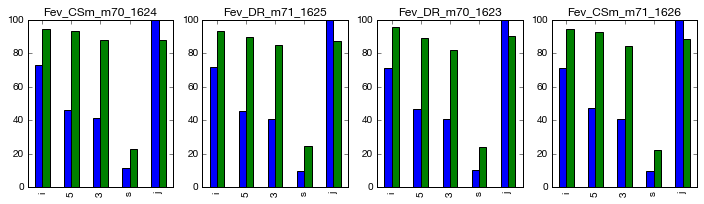

In [120]:
# plot all
import matplotlib.pylab as P
fig, axr = P.subplots(1,len(ems),figsize=(3*len(ems),3))
for i, name in enumerate(ems):
    em = ems[name]
    df = em.get_detection_percentages()
    df.ix[['i','5','3','s','j']].plot(kind='bar', ax=axr[i], legend=False)
    axr[i].set_title(name)

We can also plot the detection sensitivity against coverages. We expect detection rate is better at bigger coverage.

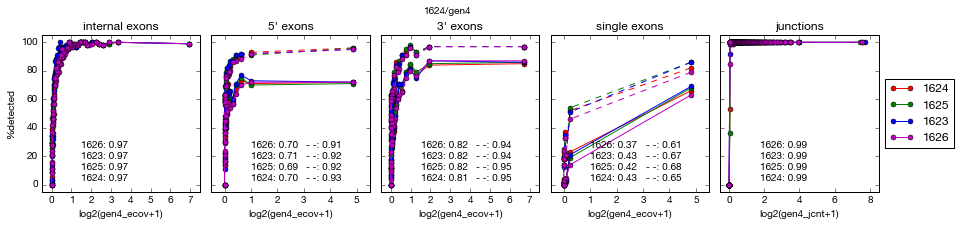

In [44]:
colors = ['ro-','go-','bo-','mo-']
for i,name in enumerate(ems):
    em = ems[name]
    if i==0:
        axr = em.plot_sensitivity(color=colors[i])
    else:
        axr = em.plot_sensitivity(color=colors[i], axr=axr, ypos=i)

These plots show percent of detected exons calculated in bins sorted by coverage (binsize 100). Numbers in inset indicate normalized area under the curve (AUC, which ranges from 0 to 1).  Dashed lines in 5',3' exon panels correspond to 5b and 3b category. 



How about the precision of the match? We can assess this by length ratio of matched exons:

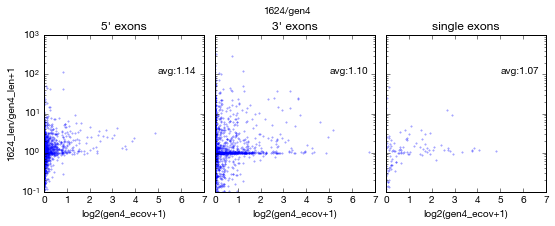

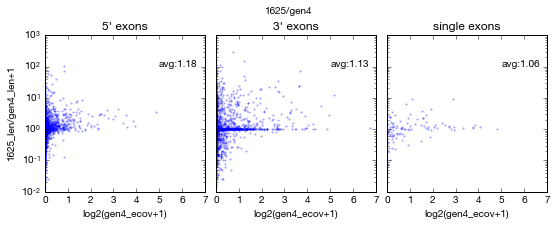

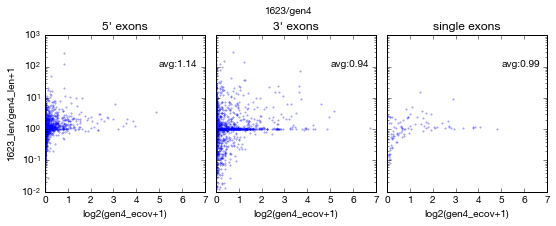

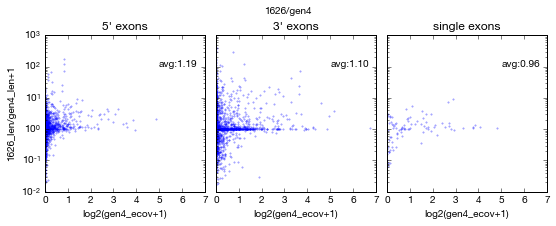

In [58]:
for name in ems:
    ems[name].plot_ratio()

Averages shown inside are geometric averages. Overall length tends to be a bit longer. 

For some genes, we see partial or disconnected reconstruction of the structure. An example is shown below:

![](_static/UCNYV53JQT9QG8GJQSS36GKMGSIT22C2.png)

These incomplete reconstructions are due to missing junctions or insufficient exon coverages.

To evaluate the *completeness* of the reconstruction, we will calculate three measures. One is the ratio of gene length. We will call this GLC (gene length completenesss). The second measure is the ratio of exon counts (ECC, exon count completeness), and the third is the ratio of junction counts (JCC, junction count completeness).

We can visualize these measures by [plot_completeness](modules.html#jgem.evaluate.EvalMatch.plot_completeness) method.

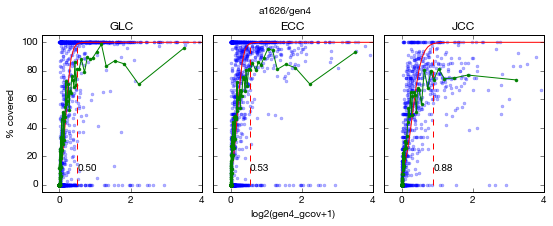

In [119]:
axr = ems[name].plot_completeness(pw='fdat', ca='g.-', cf='r-',  cd='b.', xlim=[0,4])

Blue dots are genes, green dots are binned averages, red lines are sigmoid function fit to blue dots and red dashes are 99% position of the sigmoidal fit. 

Below, we'll plot binned average of completeness measures for all 4 samples.

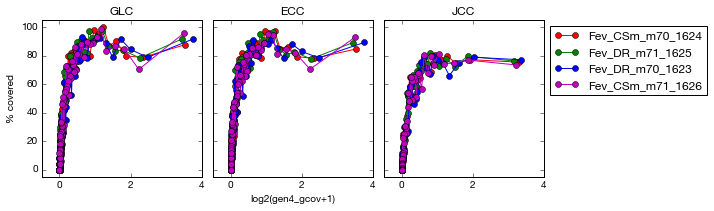

In [131]:
colors = ['ro-','go-','bo-','mo-']
for i,name in enumerate(ems):
    em = ems[name]
    if i==0:
        axr = em.plot_completeness(pw='a', ca=colors[i], xlim=(0,4), label=name, title='')
    else:
        axr = em.plot_completeness(pw='a', ca=colors[i], xlim=(0,4), axr=axr, label=name)
P.legend(bbox_to_anchor=(1,1),loc='upper left')

# Preparing for merge

Merging assembies is necessary to obtain a more complete picture of gene structures. Merging should also improve the completeness of the reconstruction.

For merging, we will repeat the assembly process but uses aggregated junctions and coverage bigwig generated from all exons from all assemblies. We need to prepare these two files first. 


## prepare aggregated junction file